In [41]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [42]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [43]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [44]:
from datetime import datetime, timedelta

In [45]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo=False)

In [46]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [47]:
# View all of the classes that automap found
Base.classes.keys()


['station', 'measurement']

In [48]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [49]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [50]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()  
print(*most_recent_date)

2017-08-23


In [51]:
# from datetime import datetime, timedelta
# import module from matplotlib called mdates to show only monthly interval dates on the x-axis
import matplotlib.dates as mdates   


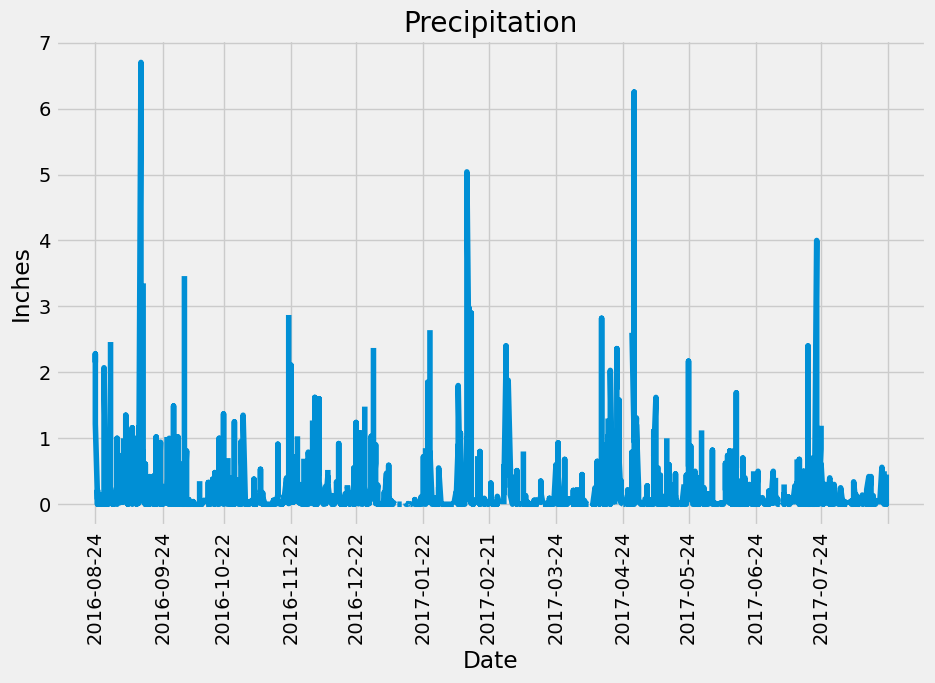

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date))
most_recent_date_pt = most_recent_date.scalar()
most_recent_date_object = datetime.strptime(most_recent_date_pt, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
date_twelve_mos_ago = most_recent_date_object - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_twelve_mos_ago).all()
# results

# TEST ONLY: Iterate on the results object to print the date and precipitation values
# for date, prcp in results:
#     print(f"Date: {date}, Precipitation: {prcp}")

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])
df.head(50)

# Sort the dataframe by date
df_sorted = df.sort_values(by='date')
df_sorted.head(5)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))

# List plot wiht markers
plt.plot(df_sorted['date'], df_sorted['prcp'])

# Create title and labels on the plot
plt.title('Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')

# set x-axis ticks to show monthly interval using mdates module.
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)

plt.show()


In [53]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Let's first temporary rename the column `prcp` as `Precipitation`
temp_df = df_sorted.rename(columns={'prcp': 'Precipitation'})

summary_stats = temp_df.describe()
summary_stats 

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).count()
station_count

9

In [55]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_query = session.query(Measurement.station,func.count(Measurement.station).label('count'))\
                .group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

station_list = [(item.station, item.count) for item in station_query]
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Extract them most active station from station_query using the .first() method.
most_active_station = station_query.first()
most_active_station_id = most_active_station[0]
print(f"The most active station id is: {most_active_station_id}")

# Query to find the min, max and avg temperature
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id)

# Create a list comprehension and assign to a variable
temp_stats_twelve_mos = [temp for temp in temperature_stats]
print(*temp_stats_twelve_mos)


The most active station id is: USC00519281
(54.0, 85.0, 71.66378066378067)


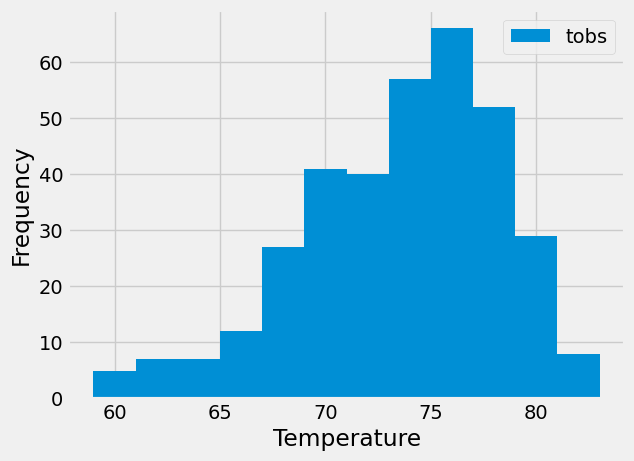

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation data (tobs) for station most_active_station_id
query = session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id, Measurement.date > date_twelve_mos_ago)

# Convert query result to pandas DataFrame
tobs_data = pd.read_sql(query.statement, engine)

# Plot the Results in a Matplotlib histogram

plt.hist(tobs_data['tobs'], bins=12, label='tobs')
plt.legend(loc='upper right')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.show()

# Close Session

In [58]:
# Close Session
session.close()

### ****  END OF CODE ****